In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as datasets

In [6]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [8]:
#descargamos los datos o los leemos si ya están disponibles
mean=(0.5,)
std=(1.0,)
datapath='./data'
trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)])

train = datasets.MNIST(root=datapath, train=True,  download=True, transform=trans)
test  = datasets.MNIST(root=datapath, train=False, download=True, transform=trans)

print('Número de datos de entrenamiento: {} \nNúmero de datos de prueba: {}'.format(len(train), len(test)))

Número de datos de entrenamiento: 60000 
Número de datos de prueba: 10000


In [9]:
#cargamos los datos para usarlos.

batch_size=100
n_iters=80000
num_epoch=int(n_iters/(len(train)/batch_size))

train_loader=torch.utils.data.DataLoader(dataset=train,
                                         batch_size=batch_size,
                                         shuffle=True)

test_loader=torch.utils.data.DataLoader(dataset=test,
                                         batch_size=batch_size,
                                         shuffle=False)

In [27]:
#Creamos la red neuronal:
class MLPnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPnet, self).__init__()
        '''
        El método init define las capas de las cuales constará el modelo, 
        aunque no la forma en que se interconectan
        '''
        # Función lineal 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Activación no lineal 1: 100 -->100
        self.relu1 = nn.ReLU()
        
        # Función lineal 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Activación no lineal 1: 100 -->100
        self.tanh2 = nn.Tanh()
        
        # Función lineal 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Activación no lineal 3: 100 -->100
        self.elu3 = nn.ELU()
        
        # Función lineal 3: (Capa de salida): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        x = x.view(-1, input_dim)  # aqui convertimos la imagen a un vector unidimensional
        # Capa 1
        z1 = self.fc1(x)
        y1 = self.relu1(z1)
        # Capa 2
        z2 = self.fc2(y1)
        y2 = self.tanh2(z2)
        # Capa 3
        z3 = self.fc3(y2)
        y4 = self.elu3(z3)
        # Capa 4 (salida)
        out = self.fc4(y4)
        return out
    
    def name(self):
        return "MLP"



In [28]:
#creamos el modelo de la clase rna
input_dim=28*28 #número de pixeles
hidden_dim=150 #numero de neuronas en capas ocultas
output_dim= 10 #numero de etiquetas

model= MLPnet(input_dim,hidden_dim,output_dim)

if use_cuda:
    model=model.cuda()

#creamos una instancia con la funcion de perdida:

error=nn.CrossEntropyLoss()

#creamos la instancia del optimizador
learning_rate=0.02
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [30]:
loss_list=[]
iteration_list=[]
accuracy_list=[]
accuracy_list_val=[]

for epoch in range(num_epoch):
    total=0
    correct=0

    #Entrena la red en lotes cada época

    for i, (images,labels) in enumerate(train_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
        images=Variable(images)
        labels=Variable(labels)

        optimizer.zero_grad() #borra gradiente
        outputs=model(images) #propagacion
        loss=error(outputs,labels)  #calcula error
        loss.backward() #retropropaga el error
        optimizer.step() #actualiza los parametros

        predicted= torch.max(outputs.data,1)[1] #etiqueta predicha (wta)
        total += len(labels)  #numero total de etiquetas en el lote
        correct +=(predicted==labels).sum() #numero de predicciones correctas

    #calcula el desempeño en entrenamiento: precisión (accuracy)
    accuracy=float(correct)/(float(total))
    #almacena la evaluación de desempeño
    iteration_list.append(epoch)
    loss_list.append(loss.item())
    accuracy_list.append(accuracy)

    #Evalua la predicción en lotes cada época

    correct=0
    total=0
    for images,labels in test_loader:

        if use_cuda:
            images,labels=images.cuda(),labels.cuda()
        images=Variable(images)
        labels=Variable(labels)

        outputs=model(images)  #inferencia

        predicted = torch.max(outputs.data, 1)[1]   # etiqueta predicha (WTA)  
        total += len(labels)                        # número total de etiquetas en lote
        correct += (predicted == labels).sum()      # número de predicciones correctas

        # calcula el desempeño: Precisión (accuracy)
    accuracy_val = float(correct) / float(total)
    accuracy_list_val.append(accuracy_val)

    # - - - - - - - - - - - - - - - 
    # Despliega evaluación
    # - - - - - - - - - - - - - - - 
    print('Epoch: {:02}  Loss: {:.6f}  Accuracy: {:.6f}  Accuracy Val: {:.6f}'.format(epoch, loss.data, accuracy, accuracy_val))    

Epoch: 00  Loss: 0.546400  Accuracy: 0.851767  Accuracy Val: 0.883800
Epoch: 01  Loss: 0.359338  Accuracy: 0.891050  Accuracy Val: 0.899600
Epoch: 02  Loss: 0.200339  Accuracy: 0.907967  Accuracy Val: 0.914500
Epoch: 03  Loss: 0.386768  Accuracy: 0.918033  Accuracy Val: 0.925100
Epoch: 04  Loss: 0.302323  Accuracy: 0.927783  Accuracy Val: 0.933200
Epoch: 05  Loss: 0.165277  Accuracy: 0.936300  Accuracy Val: 0.942100
Epoch: 06  Loss: 0.326371  Accuracy: 0.942533  Accuracy Val: 0.945200
Epoch: 07  Loss: 0.116863  Accuracy: 0.948417  Accuracy Val: 0.950500
Epoch: 08  Loss: 0.224739  Accuracy: 0.952933  Accuracy Val: 0.953200
Epoch: 09  Loss: 0.107091  Accuracy: 0.956750  Accuracy Val: 0.956600
Epoch: 10  Loss: 0.076196  Accuracy: 0.960267  Accuracy Val: 0.959600
Epoch: 11  Loss: 0.205731  Accuracy: 0.962917  Accuracy Val: 0.959500
Epoch: 12  Loss: 0.131554  Accuracy: 0.965417  Accuracy Val: 0.963800
Epoch: 13  Loss: 0.034774  Accuracy: 0.967450  Accuracy Val: 0.964000
Epoch: 14  Loss: 0.1

KeyboardInterrupt: 

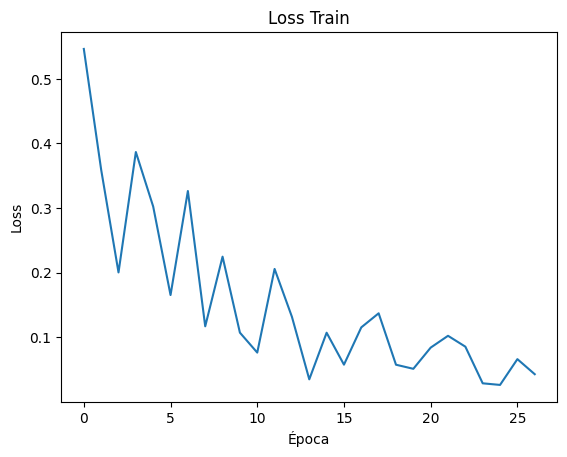

In [32]:
# Loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss Train")
plt.show()

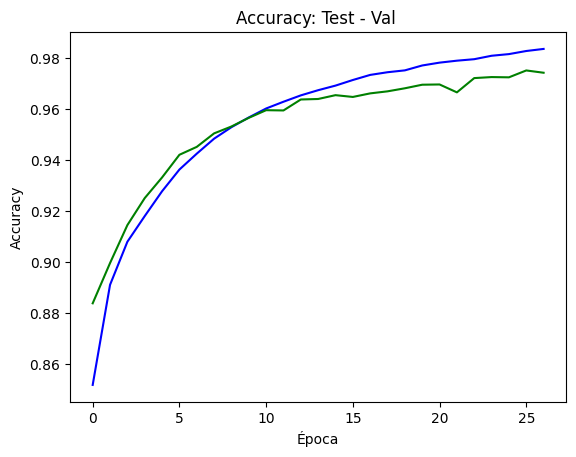

In [33]:
# Accuracy
plt.plot(iteration_list,accuracy_list,'b')
plt.plot(iteration_list,accuracy_list_val, 'g')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy: Test - Val ")
plt.show()